In [56]:
import numpy as np
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from tensorflow import keras 
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
import random
from tensorflow.keras.applications.vgg16 import VGG16 # import pretrained VGG16 model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import shutil
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier #ensemble methods used 
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score


# Get data 

In [57]:
def PrepareDateSet(pathNameLabels,pathNameImg,pathNameLabels_exo):
    """
    fonction pour recupérer la base de données 
    entrées:
        pathNameLabels: chemin d'accés aux données labels endogénes
        pathNameImg:chemin d'accés aux données des images
        pathNameLabels_exo:chemin d'accés aux données labels exogénes
    sorties:
        x_train,x_test:données d'entrées 
        y_train,y_test:données de sorties endogénes
        y_train_exo,y_test_exo : données de sorties exogénes
    """
    y_train=[]
    y_test=[]
    x_train=[]
    x_test=[]
    y_train_exo=[]
    y_test_exo=[]
    
#-------------------------labels_endogens-----------------------------------------  
    with open(pathNameLabels) as f:
        line = f.readline()
        while line:
            if 'train' in line :    
                y_train.append(int(line[16]))
            if 'test' in line : 
                y_test.append(int(line[14]))   

            line = f.readline()
    y_train=np.array(y_train)
    y_test=np.array(y_test)
    
#-------------------------labels_exogens ---------------------------------------------- 
    fold=listdir(pathNameLabels_exo)
    for path_folder in fold:
        # ------------données train exogénes--------------------
        if 'train' in path_folder :
            with open(pathNameLabels_exo+'/'+path_folder) as f:
                vect=np.zeros(3)
                line=f.readline()
                l=0
                i=0
                while line:
                    #recuperer que les 3 dernieres lignes (données exogénes)
                    l+=1
                    if l>5:
                        vect[i]=(int(line))
                        i+=1
                        line=f.readline()
                    else:
                        line=f.readline()
                        
            y_train_exo.append(vect)
        
        #------------données test exogénes---------------------
        if 'test' in path_folder :
            with open(pathNameLabels_exo+'/'+path_folder) as f:
                vect=np.zeros(3)
                line=f.readline()
                l,i=0,0
                while line:
                    #recuperer que les 3 dernieres lignes (données exogénes)
                    l+=1
                    if l>5:
                        vect[i]=(int(line))
                        i+=1
                        line=f.readline()
                    else:
                        line=f.readline()
        
            y_test_exo.append(vect)
            
        
    
#------------------------------------Image------------------------------------------------   
    for img in glob.glob(pathNameImg):   
        if 'train' in img : 
            n= np.array(mpimg.imread(img))
            x_train.append(n)
        if 'test' in img :
            n= mpimg.imread(img)
            x_test.append(n)
    y_train_exo=np.array(y_train_exo)
    y_test_exo=np.array(y_test_exo)
    x_train=np.array(x_train)
    x_test=np.array(x_test)
    return x_train,x_test,y_train, y_test,y_train_exo,y_test_exo

In [58]:
def create_data():
    """
    fonction pour creer la base de données en faisant appel a la fonction 'PrepareDateSet'
    """
    pwd = '/home/user/data/basic'
    x_train, x_test, y_train_endo, y_test_endo,y_train_exo,y_test_exo=PrepareDateSet(pwd+'/EmoLabel/list_patition_label.txt',pwd+'/Image/aligned/*.jpg',pwd+'/Annotation/manual')

    print('shape de x_train : ',np.shape(x_train))
    print('shape de x_test : ',np.shape(x_test))
    print('shape de y_train_endo : ',np.shape(y_train_endo))
    print('shape de y_test_endo : ',np.shape(y_test_endo))
    print('shape de y_train_exo : ',np.shape(y_train_exo))
    print('shape de y_test_exo : ',np.shape(y_test_exo))
    
    return x_train, x_test, y_train_endo, y_test_endo,y_train_exo,y_test_exo

In [59]:
def shape_data_exo(y_train_exo):
    """
    fonction qui redimensionne les données de sorties exogénes
    entrées:
        y_train_exo:les données de sortie exogénes
    sorties:
    y_train_exo_ohog: données de sortie exogénes train pour la caractéristique 'genre' de dimension (n*3)
    y_train_exo_ohor: données de sortie exogénes train pour la caractéristique 'race' de dimension (n*3)
    y_train_exo_ohoa: données de sortie exogénes train pour la caractéristique 'age' de dimension (n*5)
    y_test_exo_ohog: données de sortie exogénes test pour la caractéristique 'genre' de dimension (n*3)
    y_test_exo_ohor: données de sortie exogénes test pour la caractéristique 'race' de dimension (n*3)
    y_test_exo_ohoa: données de sortie exogénes test pour la caractéristique 'age' de dimension (n*5)
    """
    
#------------------------ sorties train---------------------------------------------

    y_train_exo_ohog=[] # sorties exogénes train pour le genre
    y_train_exo_ohor=[] # sorties exogénes train pour la race
    y_train_exo_ohoa=[] # sorties exogénes train pour l'age
    
    for i in range (len(y_train_exo)): 
        g=y_train_exo[i][0]
        r=y_train_exo[i][1]
        a=y_train_exo[i][2]
        
        #genre
        if g==0 : 
            temg= [1,0,0]
        if g==1 :
            temg=[0,1,0]    
        if g==2 :
            temg=[0,0,1]
        
        #race
        if r==0 : 
            temr= [1,0,0]
        if r==1 :
            temr= [0,1,0]
        if r==2 : 
            temr= [0,0,1]
        
        #age
        if a==0 : 
            tema= [1,0,0,0,0]
        if a==1 : 
            tema= [0,1,0,0,0]
        if a==2 : 
            tema= [0,0,1,0,0]
        if a==3 : 
            tema= [0,0,0,1,0]
        if a==4 :
            tema= [0,0,0,0,1]

        y_train_exo_ohog.append(temg)   
        y_train_exo_ohor.append(temr)
        y_train_exo_ohoa.append(tema)

    
    y_train_exo_ohog =np.array(y_train_exo_ohog) 
    y_train_exo_ohor =np.array(y_train_exo_ohor)
    y_train_exo_ohoa =np.array(y_train_exo_ohoa)

#-----------------------------sortie test----------------------------------------

    y_test_exo_ohog=[] # sorties exogénes train pour le genre
    y_test_exo_ohor=[] # sorties exogénes train pour la race
    y_test_exo_ohoa=[] # sorties exogénes train pour l'age
    
    for i in range (len(y_test_exo)): 
        
        #genre
        g=y_test_exo[i][0]
        r=y_test_exo[i][1]
        a=y_test_exo[i][2]
        if g==0 : 
            temg= [1,0,0]
        if g==1 :
            temg=[0,1,0]    
        if g==2 :
            temg=[0,0,1]
        
        #race
        if r==0 : 
            temr= [1,0,0]
        if r==1 :
            temr= [0,1,0]
        if r==2 : 
            temr= [0,0,1]
        
        #age
        if a==0 : 
            tema= [1,0,0,0,0]
        if a==1 : 
            tema= [0,1,0,0,0]
        if a==2 : 
            tema= [0,0,1,0,0]
        if a==3 : 
            tema= [0,0,0,1,0]
        if a==4 :
            tema= [0,0,0,0,1]

        y_test_exo_ohog.append(temg)   
        y_test_exo_ohor.append(temr)
        y_test_exo_ohoa.append(tema)


    y_test_exo_ohog =np.array(y_test_exo_ohog) 
    y_test_exo_ohor =np.array(y_test_exo_ohor)
    y_test_exo_ohoa =np.array(y_test_exo_ohoa)
 
    
    return y_train_exo_ohog,y_train_exo_ohor,y_train_exo_ohoa,y_test_exo_ohog,y_test_exo_ohor,y_test_exo_ohoa


## Endogenous and Exogenous représentation


def Endogenous_rep(x_train,xtest,y_train_endo,y_test_endo,lr=0.0001,batch_size=100,epochs=100):
    """
    modele pour la representation endogénes
    entrées:
        x_train,xtest,y_train_endo,y_test_endo: données d'entrée
    sorties:
        y_pred: données endogénes predites
        model_endo: modele endogéne
        ytest_end: sortie test endogénes
        history: l'historique du modèle
    """
    
    ytrain_end,ytest_end = data_endo(y_train_endo,y_test_endo)
    Vgg_endo = VGG16(input_shape = (100, 100,3),include_top = False,weights = 'imagenet')
    Vgg_endo.trainable=False # to kept only convolution parameters layers froozen 
    # ADD 3 fully connected layers to endogenous representation model
    model_endo=keras.Sequential([Vgg_endo,
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),  
    keras.layers.Dense(units=4096,activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=4096,activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=7,activation="softmax")
    ])
    #tf.keras.losses.CategoricalCrossentropy()
    model_endo.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr,name='Adam'),metrics=['accuracy'])
    history = model_endo.fit(x_train,ytrain_end ,batch_size=batch_size,epochs=epochs)
    y_pred=model_endo.predict(x_test)
    y_pred=np.argmax(y_pred, axis=1)

    return y_pred, model_endo,history,ytest_end

def Exogenous_rep(u,x_train,y_train_exo_oho, Save_Path):
    """
    modele pour la representation exogénes
    entrées:
        u : nombres de neuronnes de sortie (5 pour AGE, 3 pour Genre, 3 pour Race )
        y_train_exo_oho : label soit (Age, Genre, Race)
        Save_path: le chemin d'acces ou le modele sera sauvegarder
    sorties:
        history: l'historique du modèle
    """
    
    # Exogenous représentation 
    Vgg_exo = VGG16(input_shape = (100, 100,3),include_top = False,weights = 'imagenet')
    Vgg_exo.trainable=False# to kept only convolution parameters layers froozen 
    model_exo=keras.Sequential([Vgg_exo,
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),  
    keras.layers.Dense(units=4096,activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=4096,activation="relu"),
    keras.layers.BatchNormalization(),
    #keras.layers.Dense(units=3,activation="relu")
    keras.layers.Dense(units=u,activation='softmax') # units = 3 pour gender and race units= 5 pour age
    ])
    model_exo.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,name='Adam'),metrics=['accuracy'])
    history = model_exo.fit(x_train,y_train_exo_oho ,batch_size=100,epochs=50)

    model_exo.trainable=False
    #Saving a Keras model:
    model_exo.save(Save_Path)
    
    return history

## Training model

In [60]:
def visualise(history):
    """
    fonction qui permet de visualiser l'historique du modele
    """

    fig,axs = plt.subplots(2) 
    # create accuracy sublpot 
    axs[0].plot(history.history["accuracy"], label="train accuracy") 
    axs[0].set_ylabel("Accuracy") 
    axs[0].legend(loc="lower right") 
    axs[0].set_title("Accuracy eval")

    # create error sublpot 
    axs[1].plot(history.history["loss"], label="train error") 
    axs[1].set_ylabel("Error") 
    axs[1].set_xlabel("Epoch") 
    axs[1].legend(loc="upper right") 
    axs[1].set_title("Error eval") 

    plt.show()



In [61]:
def train_model_exogenous(x_train,y_train_endo,y_train_exo):
    """
    Cette fonction lance l'entrainement du model exogéne pour les trois caractéristiques différentes (Genre,Race,Age)
    """
    x_train, x_test, y_train_endo, y_test_endo,y_train_exo,y_test_exo= create_data()
    y_train_exo_ohog,y_train_exo_ohor,y_train_exo_ohoa,y_test_exo_ohog,y_test_exo_ohor,y_test_exo_ohoa=shape_data_exo(y_train_exo)
    
    history_gender=Exogenous_rep(3,x_train,y_train_exo_ohog,'/home/user/SaveModelgender')
    visualise(history_gender)
    
    history_race=Exogenous_rep(3,x_train,y_train_exo_ohor,'/home/user/SaveModelAge')
    visualise(history_race)
    
    history_age=Exogenous_rep(5,x_train,y_train_exo_ohoa,'/home/user/SaveModelRace')
    visualise(history_age)
    

In [62]:
def Prediction_GRA(y_test_exo_ohoGender,y_test_exo_ohoRace,y_test_exo_ohoAge): 
    """
    la fonction permet de prédire la sortie pour chacun des trois caractéristique genre,race et age
    entrées:
        y_test_exo_ohoGender: données de test exogenes pour le genre
        y_test_exo_ohoRace: données de test exogenes pour la race
        y_test_exo_ohoAge: données de test exogenes pour l'age
    """
    
    #chargement des modeles
    Pwd='/home/user/'
    ModelLoadGender = keras.models.load_model(Pwd+'SaveModelgender') 
    ModelLoadRace = keras.models.load_model(Pwd+'SaveModelRace')
    ModelLoadAge = keras.models.load_model(Pwd+'SaveModelAge')
    #predire la sortie 
    y_predGender=ModelLoadGender.predict(x_test)#--------------------------------------------------------------------------- ??????????
    y_predRace=ModelLoadRace.predict(x_test)
    y_predAge=ModelLoadAge.predict(x_test)
    
    ########## Mes 3 vecteurs predit #############

    y_predGender=np.argmax(y_predGender, axis=1)
    y_predRace=np.argmax(y_predRace, axis=1)
    y_predAge=np.argmax(y_predAge, axis=1)
    #############################################

    Y_testGender=np.argmax(y_test_exo_ohoGender, axis=1)
    Y_testRace=np.argmax(y_test_exo_ohoRace, axis=1)
    Y_testAge=np.argmax(y_test_exo_ohoAge, axis=1)
    ###################Confusion Matrix ###########
    
    cm_Gender  = confusion_matrix(Y_testGender, y_predGender)
    cm_Race  = confusion_matrix(Y_testRace, y_predRace)
    cm_Age  = confusion_matrix(Y_testAge, y_predAge)
    ###################### AFFICHAGE #################
    print("taux d'apprentissage du Genre est : ",  accuracy_score(Y_testGender, y_predGender)*100, "%")
    print("cm_Gender = \n", cm_Gender)
    print("la taille de y_predGender : ", np.shape(y_predGender))
    
    print("taux d'apprentissage de la Race est : ",  accuracy_score(Y_testRace, y_predRace)*100, "%")
    print("cm_Race = \n", cm_Race)
    print("la taille de y_predRace : ", np.shape(y_predRace))
    
    print("taux d'apprentissage de l'age est : ",  accuracy_score(Y_testAge, y_predAge)*100, "%")
    print("===== matrice de confusion pour la Var Age ===== \n", cm_Age)
    print("la taille de y_predAge : ", np.shape(y_predAge))
    
    y_pred_exo=[]
    for i in range (len(y_predGender)):
        y_pred_exo.append([y_predGender[i],y_predRace[i],y_predAge[i]])
    
    y_pred_exo=np.array(y_pred_exo)
    return y_pred_exo #return 3 vectors of Y_pred [Gender],[Race], [Age] de taille de 3068

In [63]:
## application du one hot encoding pour la representation endogene 
def data_endo(y_train_endo,y_test_endo):
    """
    cette fonction redimensionne les données endogene
    entrées:
        y_train_endo:données de sortie endogenes train de dimension (n*1)
        y_test_endo:données de sortie endogenes test de dimension (n*1)
    sorties:
    ytrain_end :données de sortie endogenes train de dimension (n*7)
    ytest_end: données de sortie endogenes test de dimension (n*7)
    
    """
    ytrain_end, ytest_end = [],[] 
    
    #-----------------train--------------------------------------
    for i in range(len(y_train_endo)):
        if y_train_endo[i]==1:
            ytrain_end.append([0,0,0,0,0,0,1])
        if y_train_endo[i]==2:
            ytrain_end.append([0,0,0,0,0,1,0])
        if y_train_endo[i]==3:
            ytrain_end.append([0,0,0,0,1,0,0])
        if y_train_endo[i]==4:
            ytrain_end.append([0,0,0,1,0,0,0])
        if y_train_endo[i]==5:
            ytrain_end.append([0,0,1,0,0,0,0])
        if y_train_endo[i]==6:
            ytrain_end.append([0,1,0,0,0,0,0])
        if y_train_endo[i]==7:
            ytrain_end.append([1,0,0,0,0,0,0])
            
    #-----------------test-----------------------------------------
    for i in range (len(y_test_endo)):
        if y_test_endo[i]==1:
            ytest_end.append([0,0,0,0,0,0,1])
        if y_test_endo[i]==2:
            ytest_end.append([0,0,0,0,0,1,0])
        if y_test_endo[i]==3:
            ytest_end.append([0,0,0,0,1,0,0])
        if y_test_endo[i]==4:
            ytest_end.append([0,0,0,1,0,0,0])
        if y_test_endo[i]==5:
            ytest_end.append([0,0,1,0,0,0,0])
        if y_test_endo[i]==6:
            ytest_end.append([0,1,0,0,0,0,0])
        if y_test_endo[i]==7:
            ytest_end.append([1,0,0,0,0,0,0])

    ytrain_end = np.array(ytrain_end)
    ytest_end = np.array(ytest_end)

    return ytrain_end,ytest_end


## Exagenous classifier

In [64]:

def Exagenous_classifier(y_train_exo,y_train_endo,y_test_endo,y_test_exo,r=0.0001,batch_size=32,epoch=50,loss='mse'):
    """
    la focntion crée le classifieur exagenous 
    les entrées:
        y_train_exo,y_test_exo: les donneés de sortie exogenes train et test
        y_train_endo,y_test_endo: les donneés de sortie endogénes train et test
    les sorties:
        res: 
    """
    inputL = keras.layers.Input(shape=(4,))
    hiddenL = keras.layers.Dense(2,activation='sigmoid')(inputL)
    outputL = keras.layers.Dense(4,activation='linear')(hiddenL)
    autoencoder = keras.models.Model(inputL,outputL)
    
    #crée une entrée du reseau 'y' a partir de 'y_train_exo' de dimension (n*4) -------------------------- a verifier 
    y=[]
    for i in range(len(y_train_exo)):
        a=[]
        for j in range(3):
            a.append(y_train_exo[i][j])
        a.append(y_train_endo[i])
        y.append(a)
        
    autoencoder.compile(loss=loss,optimizer=tf.keras.optimizers.Adam(learning_rate=lr,name='Adam'),metrics=['accuracy'])
    hist=autoencoder.fit(y,y,batch_size=batch_size,epochs=epoch)
    
    #crée une entrée a predire 'z' a partir de 'y_test_exo' de dimension (n*4)------------------------------- a verifier 
    z=[]
    for i in range(len(y_test_exo)):
        a=[]
        for j in range(3):
            a.append(y_test_exo[i][j])
        a.append(y_test_endo[i])
        z.append(a)
    
    res=autoencoder.predict(z)
    
    
    return res

## Deep ensemble 

In [43]:
def Deep_ensemble(y_train_endo):
    """
    cette fonction contient le classifieur deep ensemble
    les entrées:
        y_train_endo: données de sortie endogénes 
    les sorties:
        y_pred:les données predites par le classifieur adaboost
    """
    y_endo=np.reshape(y_train_endo,(np.shape(y_train_endo)[0],1))
    clf = AdaBoostClassifier(n_estimators=32)
    model = clf.fit(y_endo,y_train_endo)
    y_pred=model.predict(y_endo)
    
    return y_pred


## Tree gate 


In [44]:
# Tree gate 
def Tree_gate(y_train_exo):
    """
    cette fonction contient le bloc Tree gate
    les entrées:
        y_train_exo: les données de sortie exogénes train
    les sorties:
        g: les données predites
    """
    tree=DecisionTreeRegressor(max_features="log2",max_depth=5)
    tree.fit(y_train_exo,y_train_exo)
    # make prediction 
    g=tree.predict(y_test_exo)
    
    return g 

# THIN: 

#### Generate data set: 

In [46]:
x_train, x_test, y_train_endo, y_test_endo,y_train_exo,y_test_exo= create_data()

shape de x_train :  (12271, 100, 100, 3)
shape de x_test :  (3068, 100, 100, 3)
shape de y_train_endo :  (12271,)
shape de y_test_endo :  (3068,)
shape de y_train_exo :  (12271, 3)
shape de y_test_exo :  (3068, 3)


# Train and prediction of the Endogene representation :

In [47]:

y_pred, model_endo,history,ytest_end = Endogenous_rep(x_train,x_test,y_train_endo,y_test_endo,epochs=50)


Epoch 1/50
123/123 [==============================] - 5s 44ms/step - loss: 0.1089 - accuracy: 0.4905
Epoch 2/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0738 - accuracy: 0.6748
Epoch 3/50
123/123 [==============================] - 5s 44ms/step - loss: 0.0583 - accuracy: 0.7495
Epoch 4/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0477 - accuracy: 0.7980
Epoch 5/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0395 - accuracy: 0.8338
Epoch 6/50
123/123 [==============================] - 5s 42ms/step - loss: 0.0346 - accuracy: 0.8568
Epoch 7/50
123/123 [==============================] - 5s 42ms/step - loss: 0.0309 - accuracy: 0.8728
Epoch 8/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0281 - accuracy: 0.8849
Epoch 9/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0265 - accuracy: 0.8928
Epoch 10/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0239 - accura

## Result of the training

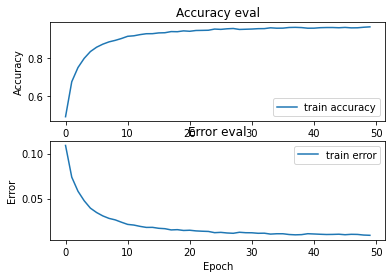

In [48]:
visualise(history)

In [67]:
y_tst_end = np.argmax(ytest_end, axis=1)
print("taux d'apprentissage  est : ",  accuracy_score(y_tst_end,y_pred)*100, "%")
print("=========== matrice de confusion ========= \n",confusion_matrix(y_tst_end,y_prd)) 


taux d'apprentissage  est :  61.34289439374185 %
=========== matrice de confusion ========= 
 [[390  17  91 102  28   9  43]
 [ 21  70  23  26   6   2  14]
 [ 85  24 244  76  20   7  22]
 [111  35  57 905  26  11  40]
 [ 49   7  39  34  17   2  12]
 [  5   4   9  11   0  30  15]
 [ 48   9  19  42  14   3 194]]


# Train and prediction of the Exogene representation :

shape de x_train :  (12271, 100, 100, 3)
shape de x_test :  (3068, 100, 100, 3)
shape de y_train_endo :  (12271,)
shape de y_test_endo :  (3068,)
shape de y_train_exo :  (12271, 3)
shape de y_test_exo :  (3068, 3)
Epoch 1/50
123/123 [==============================] - 5s 43ms/step - loss: 0.2064 - accuracy: 0.6355
Epoch 2/50
123/123 [==============================] - 5s 43ms/step - loss: 0.1540 - accuracy: 0.7435
Epoch 3/50
123/123 [==============================] - 5s 44ms/step - loss: 0.1363 - accuracy: 0.7739
Epoch 4/50
123/123 [==============================] - 5s 44ms/step - loss: 0.1220 - accuracy: 0.7980
Epoch 5/50
123/123 [==============================] - 5s 44ms/step - loss: 0.1112 - accuracy: 0.8148
Epoch 6/50
123/123 [==============================] - 5s 44ms/step - loss: 0.1011 - accuracy: 0.8335
Epoch 7/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0954 - accuracy: 0.8421
Epoch 8/50
123/123 [==============================] - 5s 44ms/step - loss: 0.08

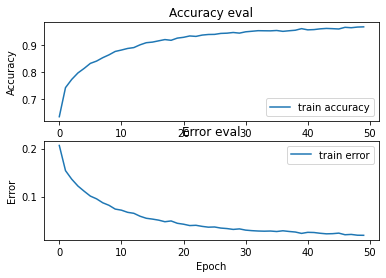

Epoch 1/50
123/123 [==============================] - 6s 48ms/step - loss: 0.2182 - accuracy: 0.6197
Epoch 2/50
123/123 [==============================] - 5s 43ms/step - loss: 0.1612 - accuracy: 0.7275
Epoch 3/50
123/123 [==============================] - 5s 43ms/step - loss: 0.1343 - accuracy: 0.7758
Epoch 4/50
123/123 [==============================] - 5s 43ms/step - loss: 0.1207 - accuracy: 0.8002
Epoch 5/50
123/123 [==============================] - 5s 43ms/step - loss: 0.1094 - accuracy: 0.8187
Epoch 6/50
123/123 [==============================] - 5s 43ms/step - loss: 0.1021 - accuracy: 0.8288
Epoch 7/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0911 - accuracy: 0.8509
Epoch 8/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0868 - accuracy: 0.8562
Epoch 9/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0776 - accuracy: 0.8721
Epoch 10/50
123/123 [==============================] - 7s 54ms/step - loss: 0.0727 - accura

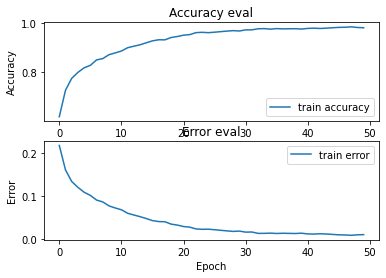

Epoch 1/50
123/123 [==============================] - 5s 44ms/step - loss: 0.1483 - accuracy: 0.5370
Epoch 2/50
123/123 [==============================] - 10s 82ms/step - loss: 0.1082 - accuracy: 0.6789
Epoch 3/50
123/123 [==============================] - 5s 42ms/step - loss: 0.0881 - accuracy: 0.7424
Epoch 4/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0751 - accuracy: 0.7808
Epoch 5/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0658 - accuracy: 0.8082
Epoch 6/50
123/123 [==============================] - 5s 44ms/step - loss: 0.0575 - accuracy: 0.8343
Epoch 7/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0515 - accuracy: 0.8530
Epoch 8/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0444 - accuracy: 0.8738
Epoch 9/50
123/123 [==============================] - 5s 43ms/step - loss: 0.0413 - accuracy: 0.8824
Epoch 10/50
123/123 [==============================] - 5s 42ms/step - loss: 0.0378 - accur

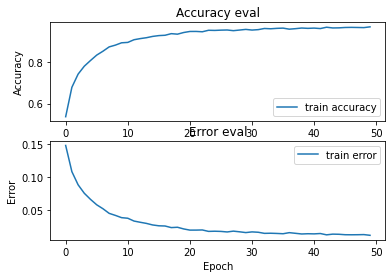

In [68]:
#pour voir la forme des données de formation et de test  
y_train_exo_ohog,y_train_exo_ohor,y_train_exo_ohoa,y_test_exo_ohog,y_test_exo_ohor,y_test_exo_ohoa=shape_data_exo(y_train_exo)

# cette fonction permet d'entraîner trois modèles pour chaque variable exogène et elle renvoie trois graphiques distincts
# graphiques de l'évolution de la courbe de perte et de précision en fonction des époques. 
train_model_exogenous(x_train,y_train_endo,y_train_exo)

In [69]:
Prediction_GRA(y_test_exo_ohog,y_test_exo_ohor,y_test_exo_ohoa)

taux d'apprentissage du Genre est :  70.92568448500653 %
cm_Gender = 
 [[ 790  391   68]
 [ 285 1294   41]
 [  45   62   92]]
la taille de y_predGender :  (3068,)
taux d'apprentissage de la Race est :  18.024771838331162 %
cm_Race = 
 [[ 220  266 1490  316   59]
 [  48   52   98   28    8]
 [  47   99  281   51    5]
 [   0    0    0    0    0]
 [   0    0    0    0    0]]
la taille de y_predRace :  (3068,)
taux d'apprentissage de l'age est :  14.21121251629726 %
===== matrice de confusion pour la Var Age ===== 
 [[ 248   40   41    0    0]
 [ 364   43   79    0    0]
 [1433   84  145    0    0]
 [ 436   29   37    0    0]
 [  75   11    3    0    0]]
la taille de y_predAge :  (3068,)


array([[0, 2, 0],
       [1, 1, 0],
       [0, 0, 1],
       ...,
       [1, 2, 2],
       [0, 3, 0],
       [0, 1, 1]])

In [ ]:
# Deep tree gate 
g=Tree_gate(y_train_exo)
# Deep ensemble 
Z_pred=Deep_ensemble(y_train_exo,y_train_endo,y_test_endo,y_test_exo)
# Exogenous classifier 
Z=Exagenous_classifier(y_train_exo,y_train_endo,y_test_endo,y_test_exo)


In [ ]:
Pwd='/home/user/'
ModelLoadEndogene = keras.models.save(Pwd+'SaveModelEndogene') 

In [ ]:
#so
#train Model Endo
#0.0001 b 100 e 50 0.87
#0.001 0.84
#0.0001 b 50  e 100 0.88
#0.0001 b 100 e 100 0.89
#loss mse ==>

In [38]:
THIN=keras.Sequential()

### Endogenous representation
Vgg_endo = VGG16(input_shape = (100, 100,3),include_top = False,weights = 'imagenet')
Vgg_endo.trainable=False # to kept only convolution parameters layers froozen 
# ADD 3 fully connected layers to endogenous representation model
model_endo=keras.Sequential([Vgg_endo,
keras.layers.Flatten(),
keras.layers.BatchNormalization(),  
keras.layers.Dense(units=4096,activation="relu"),
keras.layers.BatchNormalization(),
keras.layers.Dense(units=4096,activation="relu"),
keras.layers.BatchNormalization(),
keras.layers.Dense(units=7,activation="softmax")
])
"""
Pwd='/home/user/'
ModelLoadGender = keras.models.load_model(Pwd+'SaveModelgender') 
ModelLoadRace = keras.models.load_model(Pwd+'SaveModelRace')
ModelLoadAge = keras.models.load_model(Pwd+'SaveModelAge')
model_exo=tf.keras.layers.Add()([ModelLoadGender,ModelLoadRace,ModelLoadAge])
"""
THIN.add(model_endo)

ValueError: Input 0 of layer block1_conv1 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: [None, 7]

In [43]:
### Endogenous representation
Vgg_endo = VGG16(input_shape = (100, 100,3),include_top = False,weights = 'imagenet')
Vgg_endo.trainable=False # to kept only convolution parameters layers froozen 
# ADD 3 fully connected layers to endogenous representation model
model_endo=keras.Sequential([Vgg_endo,
keras.layers.Flatten(),
keras.layers.BatchNormalization(),  
keras.layers.Dense(units=4096,activation="relu"),
keras.layers.BatchNormalization(),
keras.layers.Dense(units=4096,activation="relu"),
keras.layers.BatchNormalization(),
keras.layers.Dense(units=7,activation="softmax")
])

Input1=keras.layers.Input(shape=(100, 100,3))
out1=keras.layers.add(model_endo)
#Input2==keras.layers.Input(shape=(100, 100,3))


TypeError: 'NoneType' object is not subscriptable

In [65]:

x_train, x_test, y_train_endo, y_test_endo,y_train_exo,y_test_exo=create_data()
y_train_exo_ohog,y_train_exo_ohor,y_train_exo_ohoa,y_test_exo_ohog,y_test_exo_ohor,y_test_exo_ohoa=shape_data_exo(y_train_exo)
y_pred_exo = Prediction_GRA(y_test_exo_ohog,y_test_exo_ohor,y_test_exo_ohoa)

shape de x_train :  (12271, 100, 100, 3)
shape de x_test :  (3068, 100, 100, 3)
shape de y_train_endo :  (12271,)
shape de y_test_endo :  (3068,)
shape de y_train_exo :  (12271, 3)
shape de y_test_exo :  (3068, 3)


NameError: name 'y_test_exo_ohoGender' is not defined

In [72]:
print(y_test_exo_ohog)
print(y_test_exo_ohor)
print(y_test_exo_ohoa)

[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 1 0]
 [1 0 0]
 [1 0 0]]
[[0 0 1]
 [0 0 1]
 [1 0 0]
 ...
 [0 0 1]
 [1 0 0]
 [1 0 0]]
[[0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 ...
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]]


In [66]:
y_pred_exo = Prediction_GRA(y_test_exo_ohog,y_test_exo_ohor,y_test_exo_ohoa)

taux d'apprentissage du Genre est :  70.5671447196871 %
cm_Gender = 
 [[ 818  378   53]
 [ 325 1263   32]
 [  50   65   84]]
la taille de y_predGender :  (3068,)
taux d'apprentissage de la Race est :  18.024771838331162 %
cm_Race = 
 [[ 202  284 1533  273   59]
 [  46   51  112   20    5]
 [  51   88  300   38    6]
 [   0    0    0    0    0]
 [   0    0    0    0    0]]
la taille de y_predRace :  (3068,)
taux d'apprentissage de l'age est :  13.820078226857888 %
===== matrice de confusion pour la Var Age ===== 
 [[ 249   37   43    0    0]
 [ 366   51   69    0    0]
 [1479   59  124    0    0]
 [ 444   26   32    0    0]
 [  76    6    7    0    0]]
la taille de y_predAge :  (3068,)


In [ ]:
e